# Image Visualization And Source Matching

This notebook demonstrates how to visualize roman images and match sources from science and template.

In [133]:
import numpy as np
from astropy.io import fits
from astropy.table import Table
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.wcs.utils import skycoord_to_pixel
import astropy.units as u
from astropy.coordinates import SkyCoord, match_coordinates_sky
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import matplotlib.patches as mpatches
import seaborn as sns
from astropy.visualization import ZScaleInterval
interval = ZScaleInterval()

In [136]:
def load_fits(image_path, return_hdr=True, return_data=True, return_wcs=True, hdu_index=0):
    with fits.open(image_path) as hdul:
        hdr = hdul[hdu_index].header if return_hdr or return_wcs else None
        wcs = WCS(hdr) if return_wcs else None
        data = hdul[hdu_index].data if return_data else None
    return hdr, wcs, data

def load_table(table_path):
    table = Table.read(table_path, format='ascii').to_pandas()
    return table

def radec_to_xy(ra, dec, wcs, origin=0):
    # ra and dec are in degree unit
    sky_coord = SkyCoord(ra, dec, frame='icrs', unit='deg')
    pixel_coords = skycoord_to_pixel(coords=sky_coord, wcs=wcs, origin=origin)
    return pixel_coords[0], pixel_coords[1]

def xy_in_image(x, y, width, height, offset=0):
    return (0 + offset <= x) & (x < width - offset) & (0 + offset <= y) & (y < height - offset)

def show_image(ax, image, title=None, xlabel=None, ylabel=None, axis_off=False, zscale=True):
    if zscale:
        image = interval(image)
    ax.imshow(image, origin='lower', cmap='gray')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if axis_off:
        ax.set_axis_off()
        
def add_circles(ax, x, y, radius=0.5, color='red', alpha=1):
    for xp, yp in zip(x, y):
        circle = Circle((xp, yp), radius=radius, color=color, alpha=alpha, fill=False)
        ax.add_patch(circle)

def one_direction_skymatch(coord, cat_coord, radius=0.4 * u.arcsec):
    # coord is in degree unit
    idx, sep2d, _ = match_coordinates_sky(coord, cat_coord)
    sep2d = sep2d.to(u.arcsec)
    matched_status = sep2d < radius
    return matched_status, idx

def two_direction_skymatch(coord, cat_coord, radius=0.4 * u.arcsec):
    # coord is in degree unit
    idx, sep2d, _ = match_coordinates_sky(coord, cat_coord)
    idx_, _, _ = match_coordinates_sky(cat_coord, coord)
    sep2d = sep2d.to(u.arcsec)
    dist_status = sep2d < radius
    matched_status = idx_[idx] == np.arange(len(idx))
    matched_status = np.logical_and(dist_status, matched_status)
    return matched_status, idx

def crop_image(image, cr, cc, half_r = 50, half_c=50, fill_edge=True, fill_value=np.nan):
    
    cr, cc = int(cr), int(cc)
    if  cr <= 0 or image.shape[0] - 1 <= cr or cc <= 0 or image.shape[1] - 1 <= cc:
        raise ValueError(f"Image center at (cr={cr}, cc={cc}) is out of bounds. "
                             f"Valid cr range: [{0}, {image.shape[0]}], y range: [{0}, {image.shape[1]}].")

    half_r, half_c = int(half_r), int(half_c)
    r_left = min(half_r, cr)
    r_right = min(half_r, image.shape[0] - 1 - cr)
    c_left = min(half_c, cc)
    c_right = min(half_c, image.shape[1] - 1 - cc)

    image_slice = image[cr - r_left: cr + r_right + 1, cc - c_left: cc + c_right + 1].copy()

    if fill_edge:
        cutout = np.full( (2 * half_r + 1, 2 * half_c + 1), fill_value)
        cutout[half_r - r_left: half_r + r_right + 1, half_c - c_left: half_c + c_right + 1] = image_slice
        return cutout
    else:
        return image_slice

In [114]:
INPUT_IMAGE_PATTERN = ("/global/cfs/cdirs/lsst/shared/external/roman-desc-sims/Roman_data"
                                "/RomanTDS/images/simple_model/{band}/{pointing}/Roman_TDS_simple_model_{band}_{pointing}_{sca}.fits.gz")
INPUT_TRUTH_PATTERN = ("/global/cfs/cdirs/lsst/shared/external/roman-desc-sims/Roman_data"
                             "/RomanTDS/truth/{band}/{pointing}/Roman_TDS_index_{band}_{pointing}_{sca}.txt")

In [121]:
science_id = {'band': 'R062', 'pointing': 26565, 'sca': 18}
template_id = {'band': 'R062', 'pointing': 54670, 'sca': 18}

In [122]:
# Load data.
science_image_path = INPUT_IMAGE_PATTERN.format(**science_id)
template_image_path = INPUT_IMAGE_PATTERN.format(**template_id)

science_truth_path = INPUT_TRUTH_PATTERN.format(**science_id)
template_truth_path = INPUT_TRUTH_PATTERN.format(**template_id)

_, science_wcs, science_image = load_fits(science_image_path, hdu_index=1)
_, template_wcs, template_image = load_fits(template_image_path, hdu_index=1)

science_truth = load_table(science_truth_path)
template_truth = load_table(template_truth_path)

# We only analyze transients in this notebook.
science_truth = science_truth[science_truth.obj_type=='transient']
template_truth = template_truth[template_truth.obj_type=='transient']

A source from the truth table can have pixel coordinates in both science image and template image. We use the following naming convention.

- `x_in_science`: x coordinate in the science image
- `y_in_science`: y coordinate in the science image
- `x_in_template`: x coordinate in the template image
- `y_in_template`: y coordinate in the template image

`Caution!`: Pixel coordinates in the truth tables are `1-based`, not `0-based`.

In [123]:
science_truth = science_truth.rename(columns={'x': 'x_in_science', 'y': 'y_in_science'})
x_in_template, y_in_template = radec_to_xy(science_truth.ra, science_truth.dec, template_wcs, origin=1)
science_truth['x_in_template'] = x_in_template
science_truth['y_in_template'] = y_in_template

template_truth = template_truth.rename(columns={'x': 'x_in_template', 'y': 'y_in_template'})
x_in_science, y_in_science = radec_to_xy(template_truth.ra, template_truth.dec, science_wcs, origin=1)
template_truth['x_in_science'] = x_in_science
template_truth['y_in_science'] = y_in_science

Some sources in the truth table are not in images. We need to remove them.

In [124]:
image_height, image_width = science_image.shape

In [125]:
science_in_science = xy_in_image(science_truth.x_in_science, science_truth.y_in_science, width=image_width, height=image_height)
science_truth = science_truth[science_in_science].copy().reset_index(drop=True)

science_in_template = xy_in_image(science_truth.x_in_template, science_truth.y_in_template, width=image_width, height=image_height)
science_truth = science_truth[science_in_template].copy().reset_index(drop=True)

template_in_template = xy_in_image(template_truth.x_in_template, template_truth.y_in_template, width=image_width, height=image_height,)
template_truth = template_truth[template_in_template].copy().reset_index(drop=True)

template_in_science = xy_in_image(template_truth.x_in_science, template_truth.y_in_science, width=image_width, height=image_height)
template_truth = template_truth[template_in_science].copy().reset_index(drop=True)

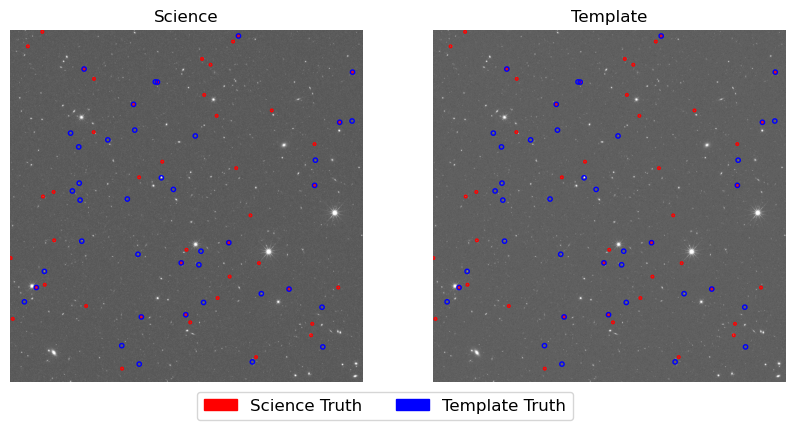

In [126]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
show_image(ax[0], science_image, title='Science', axis_off=True)
add_circles(ax[0], science_truth.x_in_science - 1, science_truth.y_in_science - 1, radius=15, color='red')
add_circles(ax[0], template_truth.x_in_science - 1, template_truth.y_in_science - 1, radius=25, color='blue')

show_image(ax[1], template_image, title='Template', axis_off=True)
add_circles(ax[1], science_truth.x_in_template - 1, science_truth.y_in_template - 1, radius=15, color='red')
add_circles(ax[1], template_truth.x_in_template - 1, template_truth.y_in_template - 1, radius=25, color='blue')

red_patch = mpatches.Patch(color='red', label='Science Truth')
blue_patch = mpatches.Patch(color='blue', label='Template Truth')

fig.legend(handles=[red_patch, blue_patch], loc='lower center', ncol=2, fontsize=12, bbox_to_anchor=(0.5, 0.05))

Some truth from the science appear in the template. We can find them using catalog matching. Since one source from a catalog could be matched by multiple sources from the other, we use two direction mapping to avoid this issue.

In [132]:
science_skycoord = SkyCoord(science_truth.ra, science_truth.dec, frame='icrs', unit='deg')
template_skycoord = SkyCoord(template_truth.ra, template_truth.dec, frame='icrs', unit='deg')
matched_status, matched_idx = two_direction_skymatch(science_skycoord, template_skycoord, radius=0.4 * u.arcsec)

science_truth['matched_status'] = matched_status
template_truth_matched = template_truth.iloc[matched_idx].copy().reset_index(drop=True)
joined_truth = science_truth.merge(template_truth_matched, left_index=True, right_index=True, suffixes=('_from_science', '_from_template'))

print(f'{joined_truth.matched_status.sum()} of {len(joined_truth)} science truth are matched.')

13 of 45 science truth are matched.


We can check the differnece pixel coordiantes to guarantee the matching is correct.

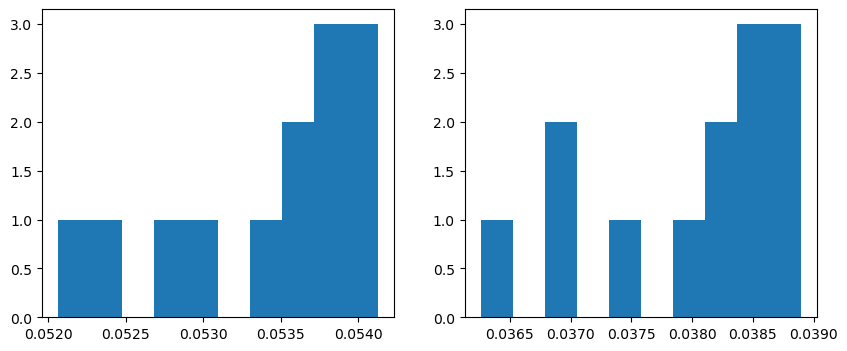

In [154]:
matched_truth = joined_truth[joined_truth.matched_status].copy().reset_index(drop=True)
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(matched_truth.x_in_science_from_science - matched_truth.x_in_science_from_template)
ax[1].hist(matched_truth.y_in_science_from_science - matched_truth.y_in_science_from_template);

Visualize a cutout

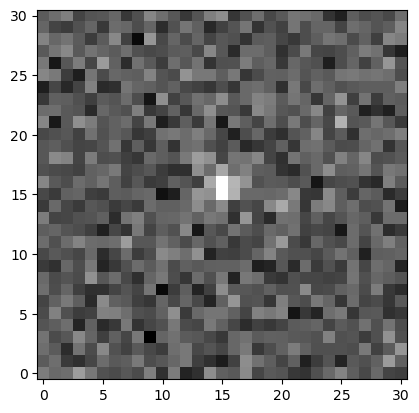

In [159]:
half_length = 15
row = joined_truth.iloc[6]
science_cutout = crop_image(science_image,
                            cr=row['y_in_science_from_science'] - 1,
                            cc=row['x_in_science_from_science'] - 1,
                            half_r=half_length, half_c=half_length,
                            fill_edge=True, fill_value=np.nan)
fig, ax = plt.subplots(1, 1)
show_image(ax, science_cutout)

Faint sources can only be observed in a few pixels. Heatmap is a good tool to visualize them.

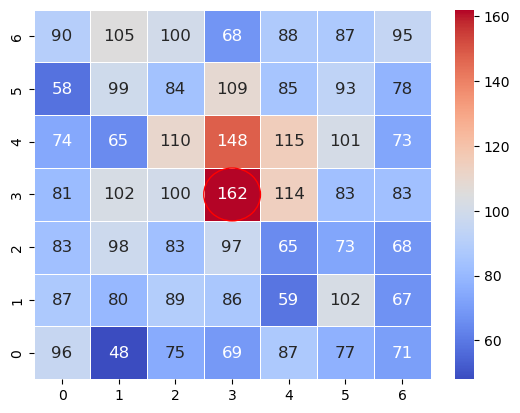

In [160]:
half_length = 3
row = joined_truth.iloc[6]
science_cutout = crop_image(science_image,
                            cr=row['y_in_science_from_science'] - 1,
                            cc=row['x_in_science_from_science'] - 1,
                            half_r=half_length, half_c=half_length,
                            fill_edge=True, fill_value=np.nan)
fig, ax = plt.subplots(1, 1)
sns.heatmap(science_cutout.astype(int), annot=True, fmt="d", cmap="coolwarm", linewidths=0.5, annot_kws={"size": 12}, ax=ax)
ax.invert_yaxis()
add_circles(ax, [half_length+0.5], [half_length+0.5], radius=0.5, color='red')